# Tension Metrics
The metrics follow [arXiv:2012.09554v2](https://arxiv.org/pdf/2012.09554.pdf). This is a notebook to compute other tension metrics. All metrics follow
$$ n_{\sigma} = \sqrt{2}\text{Erf}^{-1}(\text{PTE}) $$
where PTE is the 'probability to exceed,' which changes for each metric. In this notebook I will use the DES vs Planck test chains from Raveri's tensiometer.

### Parameter DIfference
I will start with parameter based methods. I will use normalizing flows to do the posterior estimation. First, I will start with the usual $P_{\text{shift}}$.
$$P_{\text{shift}} = \int\limits_{\mathcal{P}(\Delta\theta)>\mathcal{P(0)}}\mathcal{P}(\Delta\theta) d\Delta\theta $$

In [499]:
#Imports
#from cobaya.run import run
#from getdist.mcsamples import MCSamplesFromCobaya
import numpy as np
import getdist
import getdist.plots as gdplt
import scipy

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

import os

from getdist.mcsamples import MCSamples
from getdist import WeightedSamples

from numpy import linalg

%matplotlib inline

In [2]:
## Import chains
chain_dir = '/home/grads/data/evan/tensiometer/test_chains/'

# the Planck 2018 3x2 chain:
chain_1 = getdist.mcsamples.loadMCSamples(file_root=chain_dir+'Planck18TTTEEE', no_cache=True)

# the DES Y1 3x2 chain:
chain_2 = getdist.mcsamples.loadMCSamples(file_root=chain_dir+'DES', no_cache=True)

/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_7.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_6.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_5.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_2.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_3.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_1.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_8.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_4.txt
Removed no burn in
/home/grads/data/evan/tensiometer/test_chains/DES_4.txt
/home/grads/data/evan/tensiometer/test_chains/DES_3.txt
/home/grads/data/evan/tensiometer/test_chains/DES_6.txt
/home/grads/data/evan/tensiometer/test_chains/DES_8.txt
/home/grads/data/evan/tensiometer/test_chains/DES_2.txt
/home/grads/data/evan/tensiometer/test_chains/DES_1.txt
/home/grads/data/evan/tensiometer/test_chains/DES_7.txt
/home/grads/data/evan/tensiometer/test_chains/DES_5.t

In [500]:
### tensorflow functions

class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!',end="")
        fig,ax1 = plt.subplots(1,1)
        
        ax1.set_title('loss vs. epoch')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(self._epoch,self._loss)
        
def pregauss(chain,data):
    covmat = chain.cov().astype(np.float32)
    mean = chain.getMeans().astype(np.float32)
    
    # bijector time!
    # TriL means the cov matrix is lower triangular. Inverse is easy to compute that way
    # the cholesky factorization takes a positive definite hermitian matrix M (like the covmat) to LL^T with L lower triangluar
    gauss_approx = tfd.MultivariateNormalTriL(loc=mean,scale_tril=tf.linalg.cholesky(covmat))
    bijector = gauss_approx.bijector

    # now map the data
    new_data = bijector.inverse(data.astype(np.float32))
    return new_data,bijector

def train(base,data,bijectors,batch_size,n_epochs):
    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    xdata = np.stack(_data, axis=-1)

    x_data,bij = pregauss(data,xdata)

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 
    
    print('---   Model compiled   ---')
    print(" - N samples = {}".format(nsamples))
    if weights.all()==weights[0]:
        print(" - Uniform weights = {}".format(weights[0]))
    else:
        print(" - Non-uniform weights")
    print(" - Pre-Gaussian Map = True\n")
    print(" - Validation split = {}".format(val_split))
    print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
    print(' - Trainable parameters = {} \n'.format(model.count_params()))
    
    # now perform the fit
    model.fit(x=x_data,
              y=np.zeros((nsamples, dim),dtype=np.float32),
              batch_size=batch_size,
              epochs=n_epochs,
              steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
              validation_split=val_split,
              shuffle=True,
              verbose=False,
              callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    
    return(target_distribution,bij)

def setup(n_maf,n_params,permute):
    # Set up bijector MADE
    hidden_units=[n_params*2]*2
    print('---   MADE Info   ---')
    print(' - Hidden_units = {}'.format(hidden_units))
    print(' - Activation = {}\n'.format(tf.math.asinh))
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(n_params) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, event_shape=(n_params,), hidden_units=hidden_units, activation=tf.math.asinh, kernel_initializer='glorot_uniform')))
        
    return bijectors

def diff_boost(n_boost,chains,indexes):
    # get data
    chain1 = chains[0].samples
    chain2 = chains[1].samples
    w_chain1 = chains[0].weights
    w_chain2 = chains[1].weights
    ll_chain1 = chains[0].loglikes
    ll_chain2 = chains[1].loglikes

    idx1 = indexes[0]
    idx2 = indexes[1]

    assert len(idx1)==len(idx2)

    # ensure first chain is longer than the second.
    # Need to keep track if I flipped the data so I get the signs right (although in principle it doesn't matter, Its better for everyones results to look the same even if they import chains in different orders)
    flip=False
    if( len(chain1) < len(chain2) ):
        chain1,chain2 = chain2,chain1
        w_chain1,w_chain2 = w_chain2,w_chain1
        ll_chain1,ll_chain2 = ll_chain2,ll_chain1
        idx1,idx2 = idx2,idx1
        flip=True
    
    N1 = len(chain1)
    N2 = len(chain2)
    #print('N1 = {}'.format(N1))
    #print('N2 = {}'.format(N2))

    # set up parameter diff arrays
    diff = np.zeros((N1*n_boost,len(idx1)),dtype=np.float32)
    weights = np.zeros(N1*n_boost,dtype=np.float32)
    loglikes = np.zeros(N1*n_boost,dtype=np.float32)
        
    for i in range(n_boost):
        # find the range of indices to use for chain 2
        lower = int((i/n_boost)*N1)
        upper = lower+N1

        # compute stuff
        if flip==True:
            diff[i*N1:(i+1)*N1] = -chain1[:N1,idx1] + np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
        else:
            diff[i*N1:(i+1)*N1] = chain1[:N1,idx1] - np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')

        weights[i*N1:(i+1)*N1] = w_chain1*np.take(w_chain2, range(lower,upper), mode='wrap')
        loglikes[i*N1:(i+1)*N1] = ll_chain1+np.take(ll_chain2, range(lower,upper), mode='wrap')

    min_weight_ratio = min(chains[0].min_weight_ratio,
                               chains[1].min_weight_ratio)

    diff_samples = WeightedSamples(ignore_rows=0,
                                   samples=diff,
                                   weights=weights, loglikes=loglikes,
                                   name_tag=' ', label=' ',
                                   min_weight_ratio=min_weight_ratio)

    return diff_samples

Removed no burn in


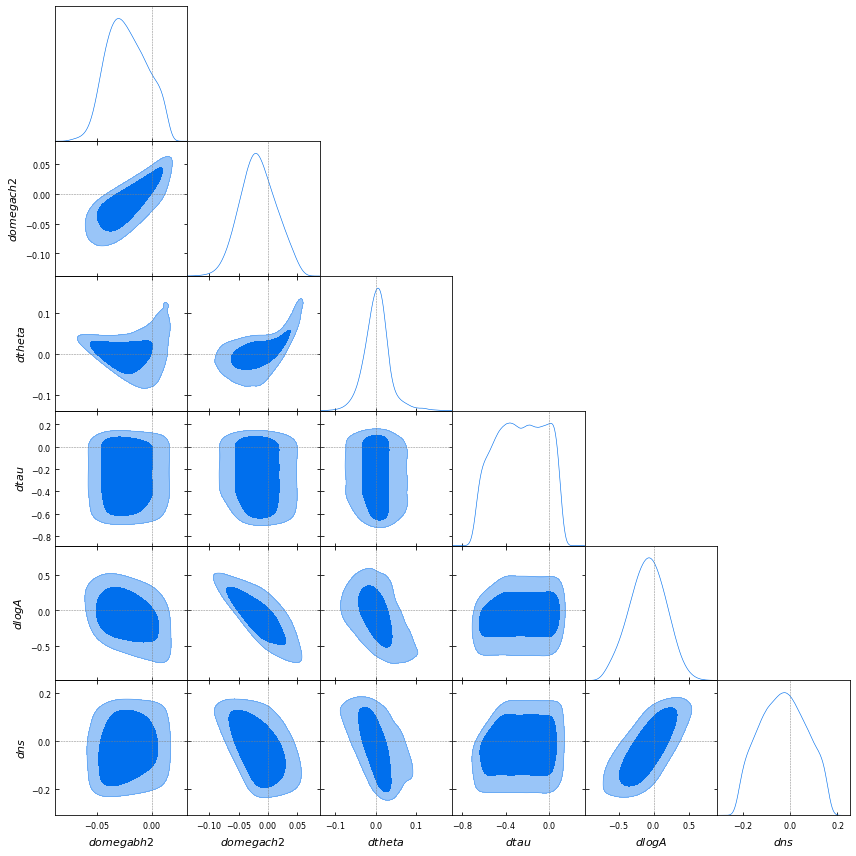

In [4]:
# Parameter Difference

param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()

# find only the params in both chains
common_params = [param for param in param_names_1 if param in param_names_2]

param_diff_names = []
param_diff = []

for param in common_params:
    param_diff_names.append('d'+param)
    data_1 = chain_1[param]
    data_2 = chain_2[param]

    if(len(data_2)>len(data_1)):
        data_1,data_2 = data_2,data_1

    _param_diff = -data_1 + np.take(data_2, range(len(data_1)), axis=0, mode='wrap')
    param_diff.append(_param_diff)

param_diff_chain = MCSamples(samples=param_diff,names=param_diff_names,labels=param_diff_names)
g = gdplt.get_subplot_plotter()
g.triangle_plot(param_diff_chain, params=param_diff_names, filled=True, markers={_p:0 for _p in param_diff_names})

2022-06-17 13:08:08.792057: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 13:08:09.256359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3376 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:09:00.0, compute capability: 5.2
2022-06-17 13:08:09.341199: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55a01b9d4c70


---   MADE Info   ---
 - Hidden_units = [12, 12]
 - Activation = <function asinh at 0x7fe8d0b58560>

---   Model compiled   ---
 - N samples = 96721
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 12 
 - Trainable parameters = 4752 

[####################] Completed!. (epoch 99/100)Removed no burn in
Removed no burn in


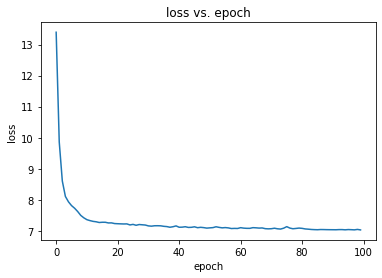

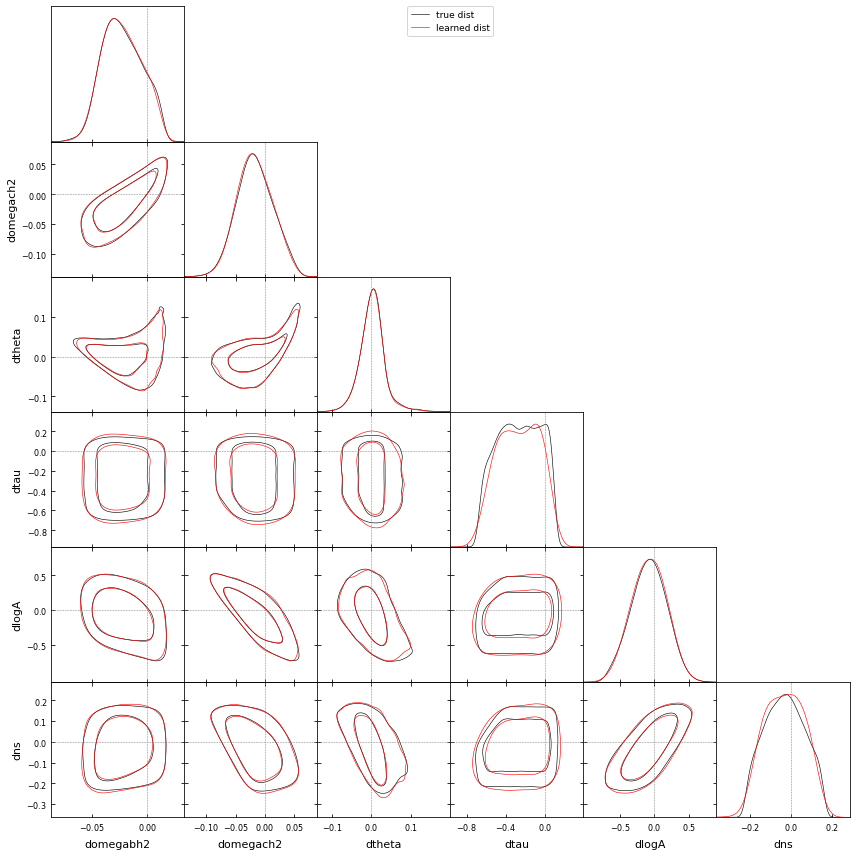

In [5]:
# Now the NF
n_params = len(param_diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=5000,n_epochs=100)

# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=param_diff_names,label='learned dist')
param_diff_chain = MCSamples(samples=param_diff,names=param_diff_names,label='true dist')
g = gdplt.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_diff_chain,sample],
                params=param_diff_names,
                filled=False,
                markers={_p:0 for _p in param_diff_names})

In [510]:
def significance_shift(trained_dist,bijector,nparams,alpha=0.32):
    # The alpha is used for beta function for the confidence. Raveri et. al. defaults to 0.32
    prob = trained_dist.prob(bijector.inverse(np.zeros(nparams,dtype=np.float32)))
    n_points = 50000
    n_pass = 0

    _s = trained_dist.sample(n_points)
    _v = trained_dist.prob(_s)
    for val in _v:
        if val>prob:
            n_pass+=1
    # use clopper-pearson to find confidence level
    low = scipy.stats.beta.ppf(alpha/2,float(n_pass),float(n_points-n_pass+1))
    high = scipy.stats.beta.ppf(1-alpha/2,float(n_pass+1),float(n_points-n_pass))

    # compute sigma based on gaussian
    n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
    sigma_high = np.sqrt(2)*scipy.special.erfinv(high)
    sigma_low = np.sqrt(2)*scipy.special.erfinv(low)
    
    return n_sigma,sigma_high,sigma_low

In [7]:
sigma,high,low = significance_shift(trained_dist,bijector,n_params)
print('n sigma = {:.5f} +{:.5f}/-{:.5f}'.format(sigma,high-sigma,sigma-low))

n sigma = 2.07788 +0.00929/-0.00932


### Parameter Difference Update
We have one chain with data set *A* and another chain with two data sets *A+B*. Then the quantity

$$ Q_{UDM} = (\mu_A - \mu_{A+B})^T (C_A-C_{A+B})^{-1}(\mu_A - \mu_{A+B})$$

In practice $Q_{UDM}$ should be $\chi^2$ distributed with $\text{rank}(C_A-C_{A+B})$ degrees of freedom. This allows us to compute $n_\sigma$ using 

$$ \text{PTE} = \int\limits_{Q_{UDM}}^{\infty}\chi^2(x,d) dx $$

In [9]:
## Import chains
chain_dir = '/home/grads/data/evan/tensiometer/test_chains/'

# the Planck 2018 3x2 chain:
chain_1 = getdist.mcsamples.loadMCSamples(file_root=chain_dir+'Planck18TTTEEE', no_cache=True)

# the Planck 2018 + DES Y1 3x2 chain:
chain_2 = getdist.mcsamples.loadMCSamples(file_root=chain_dir+'Planck18TTTEEE_DES', no_cache=True)

/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_7.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_6.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_5.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_2.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_3.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_1.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_8.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_4.txt
Removed no burn in
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_DES_3.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_DES_1.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_DES_4.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_DES_5.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_DES_6.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_DES_8.txt
/home/grads/data/ev

In [10]:
### Get means and covariance
param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()
common_params = [param for param in param_names_1 if param in param_names_2]

cov_A = chain_1.cov(common_params)
mean_A = chain_1.mean(common_params)
cov_AB = chain_2.cov(common_params)
mean_AB = chain_2.mean(common_params)

# difference tensors
cov_diff = cov_A - cov_AB
inv_cov_diff = np.linalg.inv(cov_diff)
mean_diff = mean_AB - mean_A

In [11]:
#find degrees of freedom
rank = np.linalg.matrix_rank(cov_diff)
print('df = {}'.format(rank))

# compute qudm
qudm = mean_diff @ inv_cov_diff @ mean_diff
print('Q_UDM = {:.5e}'.format(qudm))

pte = scipy.stats.chi2.cdf(qudm, rank)
print(pte)
n_sigma = np.sqrt(2)*scipy.special.erfinv(pte)
print('\nn_sigma = {}'.format(n_sigma))

df = 6
Q_UDM = 1.31268e+01
0.9589339291268658

n_sigma = 2.0428623037079845


### Eigentension
The next metric is not entirely a parameter or evidence based metric. The steps for computing this metric are as follows:

1. Find the eigenvalues and eigenvectors of the DES covariance.
2. Find the ratio of the variance in the prior and the posterior. Consider this mode well measured if the ratio is greater than 10^2
3. three

In [470]:
## Import chains
chain_dir = '/home/grads/data/evan/tensiometer/test_chains/'

# the Planck 2018 + DES Y1 3x2 chain:
chain1 = getdist.mcsamples.loadMCSamples(file_root=chain_dir+'DES', no_cache=True)

/home/grads/data/evan/tensiometer/test_chains/DES_4.txt
/home/grads/data/evan/tensiometer/test_chains/DES_3.txt
/home/grads/data/evan/tensiometer/test_chains/DES_6.txt
/home/grads/data/evan/tensiometer/test_chains/DES_8.txt
/home/grads/data/evan/tensiometer/test_chains/DES_2.txt
/home/grads/data/evan/tensiometer/test_chains/DES_1.txt
/home/grads/data/evan/tensiometer/test_chains/DES_7.txt
/home/grads/data/evan/tensiometer/test_chains/DES_5.txt
Removed no burn in


In [481]:
# get cov of chains
param_names_1 = chain1.getParamNames().list()#.getParamNames()#.getRunningNames()
param_names_2 = chain2.getParamNames().getRunningNames()

###
# Parameters of interest
param_names = ['omegabh2','omegach2','H0','ns','sigma8','omegam']
common_params = [param for param in param_names_1 if param in param_names]

#print(param_names_1)
#print(common_params)

cov_1 = chain1.cov(common_params)
#mean_A = chain.mean(common_params)
#cov_2 = chain2.cov(common_params)
#mean_AB = update_chain.mean(common_params)

evals1,evecs1 = np.linalg.eig(cov_1)
#evals2,evecs2 = np.linalg.eig(cov_2)

# compute diagonal cov
inv_evecs = np.linalg.inv(evecs1)
d_cov = np.transpose(inv_evecs) @ cov_1 @ np.transpose(evecs1)
#print(d_cov)
print(evecs1)
print(common_params)
print(chain1.ranges)

[[ 1.28205285e-03 -4.68246978e-03  1.47481349e-01 -2.01896447e-01
  -8.68561910e-01 -4.27859459e-01]
 [ 2.20680376e-03 -1.46214479e-01  7.06898151e-02 -2.88735361e-01
  -3.51435087e-01  8.75639582e-01]
 [-6.78108806e-04  8.18539250e-01  5.63171555e-01 -4.59434273e-03
   4.01538452e-02  1.05817755e-01]
 [ 9.99994440e-01 -2.45517452e-04  1.68392457e-03  9.29323898e-04
   2.27515450e-03 -1.47758079e-03]
 [-9.02730373e-04 -2.17654949e-01  3.21969444e-01 -8.30774006e-01
   3.46167177e-01 -1.97342397e-01]
 [ 1.82502073e-03  5.11096038e-01 -7.43251534e-01 -4.30885478e-01
  -2.53843750e-02 -6.92854373e-03]]
['omegabh2', 'omegach2', 'ns', 'H0', 'omegam', 'sigma8']
              omegabh2    5.0000000E-03    1.0000000E-01
              omegach2    1.0000000E-03    9.9000000E-01
                 theta    5.0000000E-01    1.0000000E+01
                   tau    1.0000000E-02    8.0000000E-01
                omegak    0.0000000E+00    0.0000000E+00
                   mnu    6.0000000E-02    6.000000

In [482]:
# get prior cov assumming hard prior.
# \sigma^2 = \frac{1}{12} (max-min)^2 
idx = [param_names_1.index(param) for param in common_params]
samples = chain1.samples
cov_prior = np.zeros((len(idx),len(idx)))

vecs = samples[...,idx]
pr_samples = []

# DES Priors. 
# omega_m from planck
# sigma8 just estimated, canno find anywhere
prior_lims = {
    'omegam': [0.1,0.9],
    'sigma8': [0.6,1.2]
}


for i in range(len(common_params)):
    name = common_params[i]
    # get prior limits
    try:
        amin = chain1.ranges.lower[name]
    except:
        amin = prior_lims[name][0]
    try:
        amax = chain1.ranges.upper[name]
    except:
        amax = prior_lims[name][1]
    
    # sample from prior
    pr_samples.append(np.random.uniform(amin,amax,1000000))
    cov_prior[i,i] = ((amax-amin)**2)/12

    
#change to eigenbasis
t_pr_samples = pr_samples
t_pr_samples = np.linalg.inv(evecs1) @ pr_samples
transformed_vecs=np.transpose(np.linalg.inv(evecs1) @ np.transpose(vecs))

#print(cov_prior)
#print(inv_evecs @ cov_prior @ evecs1)
dcov_prior=inv_evecs @ cov_prior @ evecs1
# variances
for i in range(len(common_params)):
    cov_prior[i,i] = np.var(pr_samples[i])
    
'''
# plot initial
param_basis = MCSamples(samples=vecs, names=common_params,label='posterior')
param_basis_prior = MCSamples(samples=np.transpose(pr_samples),names=common_params,label='prior')
g = gdplt.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_basis,param_basis_prior],
                params=common_params,
                filled=False,
                markers={_p:0 for _p in common_params})

# plot eigenbasis
eigen_basis = MCSamples(samples=transformed_vecs, names=common_params,label='posterior')
eigen_basis_prior = MCSamples(samples=np.transpose(t_pr_samples),names=common_params,label='prior')
g = gdplt.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([eigen_basis,eigen_basis_prior],
                params=common_params,
                filled=False,
                markers={_p:0 for _p in common_params})
'''

"\n# plot initial\nparam_basis = MCSamples(samples=vecs, names=common_params,label='posterior')\nparam_basis_prior = MCSamples(samples=np.transpose(pr_samples),names=common_params,label='prior')\ng = gdplt.get_subplot_plotter()\ng.settings.num_plot_contours = 2\ng.triangle_plot([param_basis,param_basis_prior],\n                params=common_params,\n                filled=False,\n                markers={_p:0 for _p in common_params})\n\n# plot eigenbasis\neigen_basis = MCSamples(samples=transformed_vecs, names=common_params,label='posterior')\neigen_basis_prior = MCSamples(samples=np.transpose(t_pr_samples),names=common_params,label='prior')\ng = gdplt.get_subplot_plotter()\ng.settings.num_plot_contours = 2\ng.triangle_plot([eigen_basis,eigen_basis_prior],\n                params=common_params,\n                filled=False,\n                markers={_p:0 for _p in common_params})\n"

In [491]:
# get the ratio of variances
r = np.zeros(len(cov_prior))
robust=[]

for i in range(len(cov_prior)):
    r[i] = cov_prior[i,i]/d_cov[i,i]
    r_new[i] = new_pr_covmat[i,i]/d_cov[i,i]

for i in range(len(r)):
    if( r[i]>100 ):
        print('{} is robust!'.format(i))
        robust.append(i)

3 is robust!


In [492]:
for i in robust:
    print(inv_evecs @ evecs1[i])

print(common_params)
print(r)

[ 0.00220493 -0.0045188   0.15024382 -0.20308478 -0.86757598 -0.428334  ]
['omegabh2', 'omegach2', 'ns', 'H0', 'omegam', 'sigma8']
[1.23175883e-04 6.60015437e-03 3.66322123e+00 6.36098958e+05
 6.50804041e-04 1.08833905e-03]


In [493]:
# now project planck onto the eigenbasis of DES and take the well measured directions

chain2 = getdist.mcsamples.loadMCSamples(file_root=chain_dir+'Planck18TTTEEE', no_cache=True)

planck = chain2.samples[...,idx]
planck_proj = np.transpose(np.linalg.inv(evecs1) @ np.transpose(planck))

well_measured_planck = planck_proj[...,robust]
well_measured_des = transformed_vecs[...,robust]

diff = well_measured_des - np.take(well_measured_planck,len(well_measured_planck),mode='wrap')

/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_7.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_6.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_5.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_2.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_3.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_1.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_8.txt
/home/grads/data/evan/tensiometer/test_chains/Planck18TTTEEE_4.txt
Removed no burn in


(array([3.0000e+00, 2.0000e+01, 6.9000e+01, 1.6000e+02, 6.1100e+02,
        4.8050e+03, 3.3250e+04, 4.6703e+04, 1.0710e+04, 3.9000e+02]),
 array([-0.07463515, -0.0583464 , -0.04205766, -0.02576892, -0.00948018,
         0.00680856,  0.0230973 ,  0.03938605,  0.05567479,  0.07196353,
         0.08825227]),
 <BarContainer object of 10 artists>)

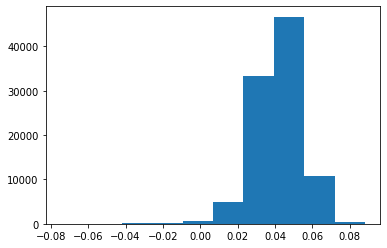

In [494]:
plt.hist(diff)

In [506]:
# if I ensure at least 2 dim subspace I can use normalizing flows
if( len(robust)<2 ):
    add_vec = -1*np.sort(-1*r)[1]
    new_idx = np.where(r==add_vec)
    print('adding the {} eigenvector to well-measured subspace'.format(new_idx[0]))
    robust.append(new_idx[0][0])
    
print(robust)
well_measured_planck = planck_proj[...,robust]
well_measured_des = transformed_vecs[...,robust]

diff = well_measured_des - np.take(well_measured_planck,len(well_measured_planck),mode='wrap')
print(diff)

[3, 2]
[[0.06141552 0.64945827]
 [0.06884862 0.80088551]
 [0.05178285 0.74456024]
 ...
 [0.06033214 0.85524263]
 [0.06598701 0.81675696]
 [0.06740084 0.81147442]]


Removed no burn in
---   MADE Info   ---
 - Hidden_units = [4, 4]
 - Activation = <function asinh at 0x7fe8d0b58560>

---   Model compiled   ---
 - N samples = 96721
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 4 
 - Trainable parameters = 208 

[####################] Completed!Removed no burn in
Removed no burn in


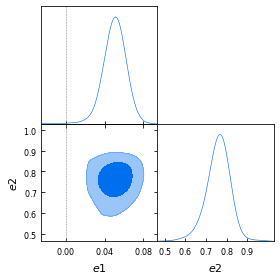

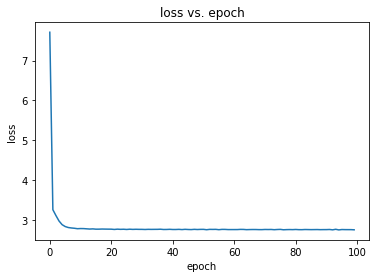

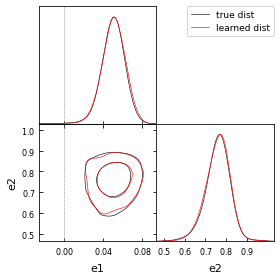

In [511]:
common_params = ['e1','e2']

param_diff_chain = MCSamples(samples=diff,names=common_params,labels=common_params)
g = gdplt.get_subplot_plotter()
g.triangle_plot(param_diff_chain, params=common_params, filled=True, markers={_p:0 for _p in common_params})
n_params = len(common_params)

# Now the NF
n_params = len(param_diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,param_diff_chain,bijectors=bijectors,batch_size=5000,n_epochs=100)

# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=common_params,label='learned dist')
param_diff_chain = MCSamples(samples=diff,names=common_params,label='true dist')
g = gdplt.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([param_diff_chain,sample],
                params=common_params,
                filled=False,
                markers={_p:0 for _p in common_params})

In [512]:
sigma,high,low = significance_shift(trained_dist,bijector,n_params)
print('n sigma = {:.5f} +{:.5f}/-{:.5f}'.format(sigma,high-sigma,sigma-low))

n sigma = inf +nan/-inf


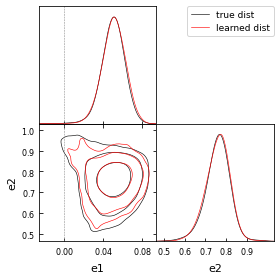

In [516]:
g = gdplt.get_subplot_plotter()
g.settings.num_plot_contours = 3
g.triangle_plot([param_diff_chain,sample],
                params=common_params,
                filled=False,
                markers={_p:0 for _p in common_params})